In [11]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

In [2]:
xlsx = pd.ExcelFile('TFSCD10.1.xlsx', engine='openpyxl')

# Get all sheet names
sheet_names = xlsx.sheet_names
profile_sheets = [name for name in sheet_names if name.startswith("Profile")]

profiles = {sheet: xlsx.parse(sheet) for sheet in profile_sheets}

for name in profiles:
    df = profiles[name]
    df = df.iloc[1:, 1:]  # skip first row and first column
    df.reset_index(drop=True, inplace=True)  
    df.columns.values[0] = "Distance"
    df.columns.values[1] = "Height"
    spline = UnivariateSpline(df['Distance'], df['Height'], s=.001)  # s is smoothing factor
    y_smooth = spline(df['Distance'])
    df['Smooth'] = y_smooth
    df['Derivative'] = np.gradient(y_smooth, df['Distance'])
    df['Derivative2'] = df['Derivative']**2
    df["Baseline"] = df["Derivative2"].apply(lambda x: x if x >= 0.1 else np.nan)

    profiles[name] = df  

for name, df in profiles.items():
    print(f"--- {name} ---")
    print(df.head(), "\n")


FileNotFoundError: [Errno 2] No such file or directory: 'TFSCD10.1.xlsx'

In [ ]:
for name, df in profiles.items():
    spline = UnivariateSpline(df['Distance'], df['Height'], s=.001)  # s is smoothing factor
    y_smooth = spline(df['Distance'])
    df['Smooth'] = y_smooth
    plt.figure(figsize=(8, 5))
    plt.plot(df['Distance'], df['Height'], 'o', label='Original')
    plt.plot(df['Distance'], y_smooth, '-', label='Smoothed')
    plt.title(f"{name} - Smoothed Curve")
    plt.xlabel("Distance")
    plt.ylabel("Height")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    


NameError: name 'plt' is not defined

In [ ]:
df = profiles['Profile 1']
plt.figure(figsize=(8, 5))
plt.plot(df['Distance'], df['Height'], 'o', label='Original')
plt.plot(df['Distance'], df['Derivative2'], '-', label='Derivative^2')
plt.plot(df['Distance'], df['Baseline'], '-', label='Baseline')
plt.plot(df['Distance'][peaks], df['Baseline'][peaks], "x", label="Peaks", markersize=8, color='red')
plt.title(f"{name} - Smoothed Curve")
plt.xlabel("Distance")
plt.ylabel("Height")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [93]:
class File:
    def __init__(self, filename):
        self.filename = filename

    def load(self):
        from pandas import ExcelFile
        xlsx = ExcelFile(self.filename, engine='openpyxl')

        self.profile_names = [
            name for name in xlsx.sheet_names if name.startswith("Profile")]
        data = {sheet: xlsx.parse(sheet) for sheet in self.profile_names}
        for name in data:
            df = data[name]
            df = df.iloc[1:, 1:]
            df.reset_index(drop=True, inplace=True)
            df.columns.values[0] = "Distance"
            df.columns.values[1] = "Height"

            from scipy.interpolate import UnivariateSpline
            spline = UnivariateSpline(df['Distance'], df['Height'], s=2)
            df['Smooth'] = spline(df['Distance'])

            from numpy import gradient
            df['Derivative'] = gradient(df['Smooth'], df['Distance'])
            df['Derivative2'] = df['Derivative']**2
            df["Baseline"] = df["Derivative2"].apply(
                lambda x: x if x >= 0.1 else 0)
            data[name] = df
        self.data = data

    def findPeaks(self):      
        from scipy.signal import find_peaks  
        peaks_dict = {}
        for name in self.data:
            df = self.data[name]
            peaks, _ = find_peaks(df['Baseline'])
            peaks_df = df.iloc[peaks].copy()
            peaks_dict[name] = peaks_df
        self.peaks = peaks_dict
        
    def analyzePeaks(self):
        rows = []
        for name, df in self.peaks.items():
            rows.append({
                "name": name,
                "num_peaks": len(df),
                "avg_height": df["Height"].mean(),
                "std_height": df["Height"].std(),
                "max_height": df["Height"].max()
            })

        from pandas import DataFrame
        self.analyzedPeaks = DataFrame(rows)
        return self.analyzedPeaks
    
    def save(self):
        if not hasattr(self, 'analyzedPeaks') or self.analyzedPeaks is None:
            print('No Peaks found, run .analyzePeaks()')
            return
        
        new_filename = self.filename.replace(".xlsx", "_analyzed.csv")

        self.analyzedPeaks.to_csv(new_filename, index=False)

        
        
    def getProfile(self, profile_id):
        return self.data['Profile ' + str(profile_id)]
    
            
    def getPeaks(self, profile_id):
        return self.peaks['Profile ' + str(profile_id)]


In [94]:
file = File('TFSCD10.1.xlsx')
file.load()
file.findPeaks()
file.analyzePeaks()
file.save()

In [95]:
df = file.getProfile(1)

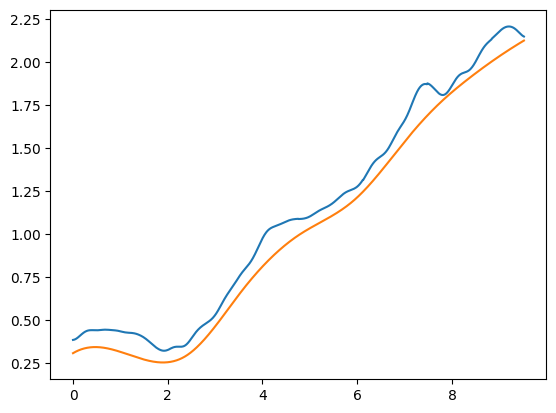

In [96]:
plt.plot(df['Distance'], df['Height'])
plt.plot(df['Distance'], df['Smooth']-0.1)

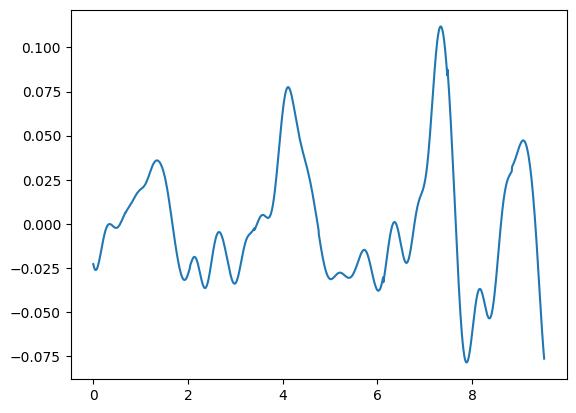

In [97]:
plt.plot(df['Distance'], df['Height']-df['Smooth'])


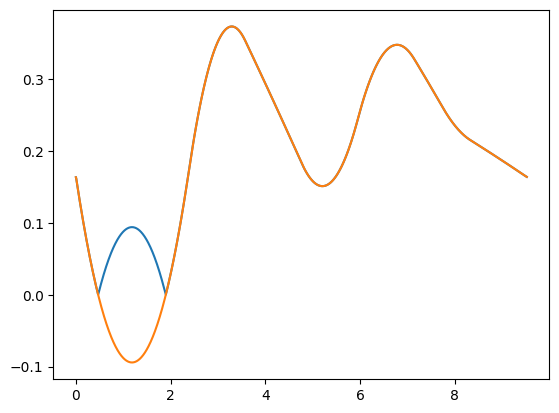

In [98]:
plt.plot(df['Distance'], np.abs(df['Derivative']))
plt.plot(df['Distance'], (df['Derivative']))

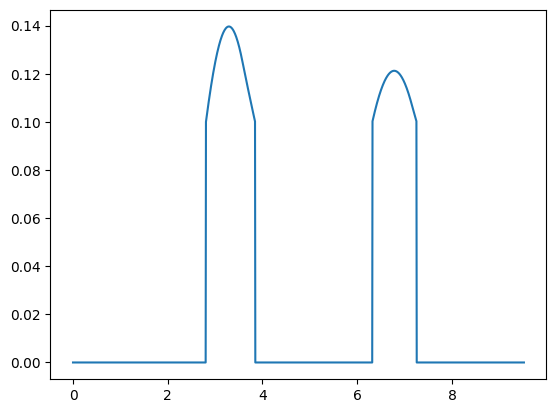

In [99]:
plt.plot(df['Distance'], df['Baseline'])

In [100]:
df['Distance']

0              0
1       0.006393
2       0.012785
3       0.019179
4       0.025571
          ...   
1485    9.493542
1486    9.499935
1487    9.506328
1488     9.51272
1489    9.519113
Name: Distance, Length: 1490, dtype: object

In [101]:
file.getPeaks(1)

,Distance,Height,Smooth,Derivative,Derivative2,Baseline
515,3.292361,0.663635,0.669661,0.373711,0.139660,0.139660
1061,6.782928,1.563049,1.562587,0.348196,0.121241,0.121241


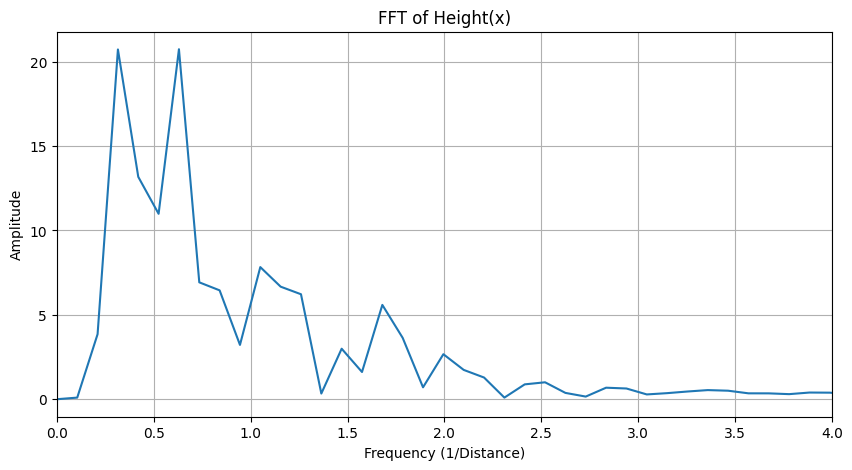

In [102]:
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')
df['Height'] = pd.to_numeric(df['Height'], errors='coerce')
df = df.dropna(subset=['Distance', 'Height'])

# Step 2: Sort by Distance just in case
df = df.sort_values('Distance')

# Step 3: Interpolate to uniform spacing (important for FFT)
x_uniform = np.linspace(df['Distance'].min(), df['Distance'].max(), len(df))
y_interp = np.interp(x_uniform, df['Distance'], df['Height']-df['Smooth'])

# Step 4: Compute FFT
fft_y = np.fft.fft(y_interp)
freqs = np.fft.fftfreq(len(x_uniform), d=(x_uniform[1] - x_uniform[0]))

# Step 5: Plot the magnitude spectrum
plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], np.abs(fft_y)[:len(freqs)//2])  # only positive freqs
plt.title('FFT of Height(x)')
plt.xlabel('Frequency (1/Distance)')
plt.ylabel('Amplitude')
plt.xlim(0, 4)
plt.grid(True)
plt.show()
